# ML Marathon Demo
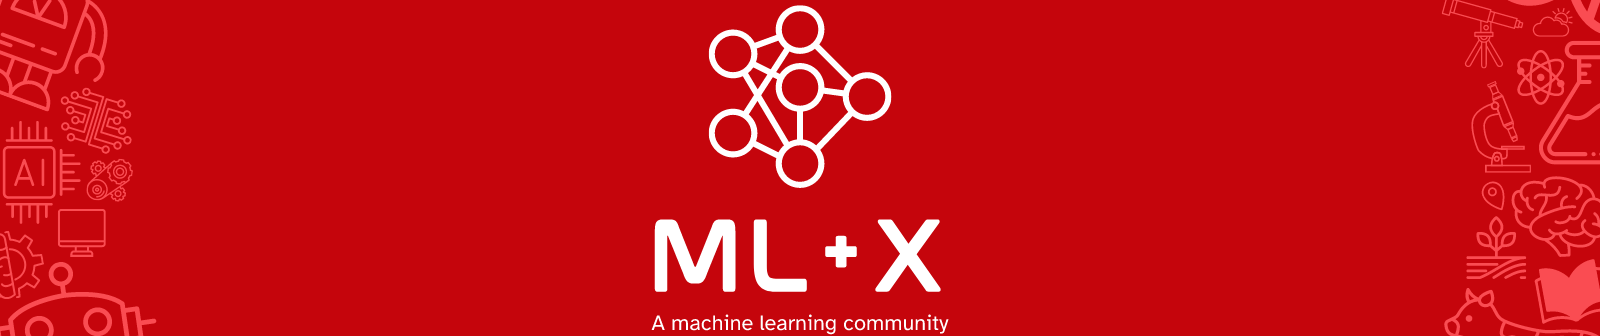

# Contrastive Learning and CLIP embeddings

This Demo walks through:
- What **contrastive learning** is and how **CLIP** works at a high level.
- Extracting **image embeddings** and **text embeddings** using CLIP.
- Performing **zero-shot classification** with text prompts (CLIP magic!).
- Training a simple **k-NN** classifier on CLIP embeddings.
- Visualizing the embedding space with **t-SNE** and **UMAP** and comparing them.

We'll work end‑to‑end on a small subset of **CIFAR‑10** to keep things fast and simple.




## Learning Objectives
By the end of this notebook, you will be able to:
1. Explain the basic idea of **contrastive learning** and **CLIP**.
2. Compute **CLIP embeddings** for images and text.
3. Do **zero-shot** inference with text prompts.
4. Train and evaluate a **k-NN** classifier on CLIP embeddings.
5. Visualize embeddings using **t-SNE** and **UMAP**.


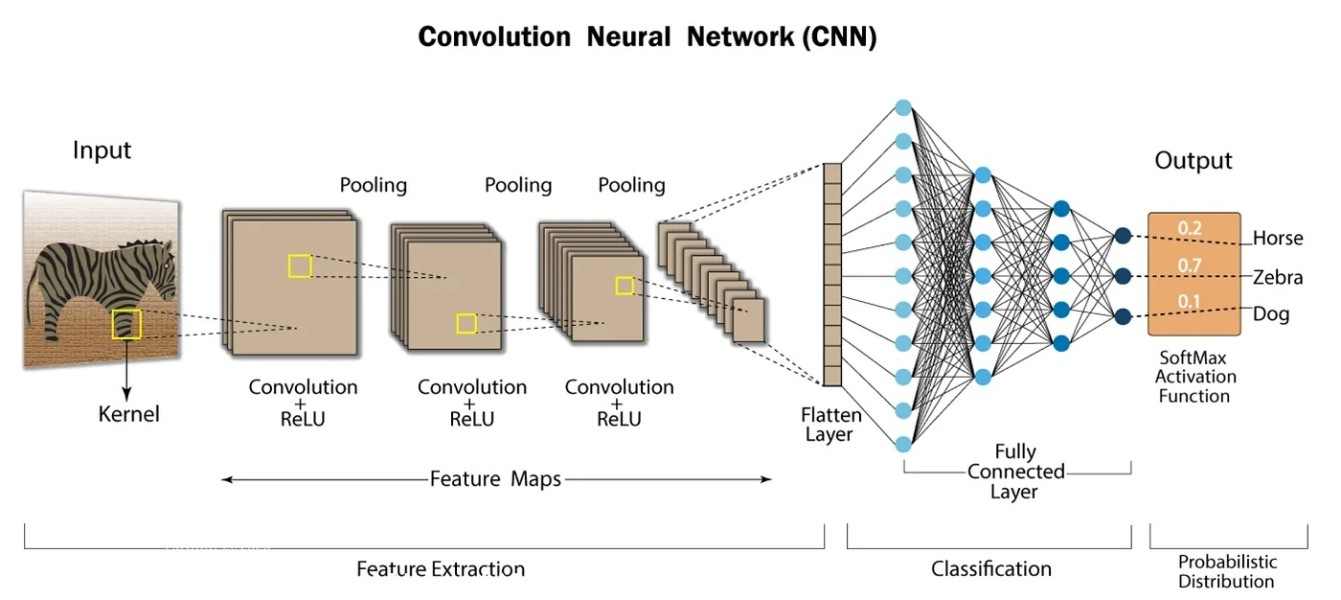

# Contrastive Learning & CLIP (Quick Primer)

**Contrastive learning** trains models to bring **matching pairs** close together in an embedding space, and **push non‑matching pairs** apart.
- In **CLIP** (Contrastive Language–Image Pretraining), a large image encoder and a text encoder are trained jointly on (image, text) pairs.
- The training objective (InfoNCE) maximizes similarity of the true image–caption pair while minimizing similarity to other pairs in the batch.
- Result: a **shared** embedding space where semantically related images and texts are near each other.

**Why is this powerful?**
- Once trained, we can embed **any text prompt** (e.g., *"a photo of a dog"*) and **any image**, then compare them via cosine similarity.
- This enables **zero‑shot** classification: pick the label whose text prompt has the highest similarity to the image embedding—no task‑specific training needed.




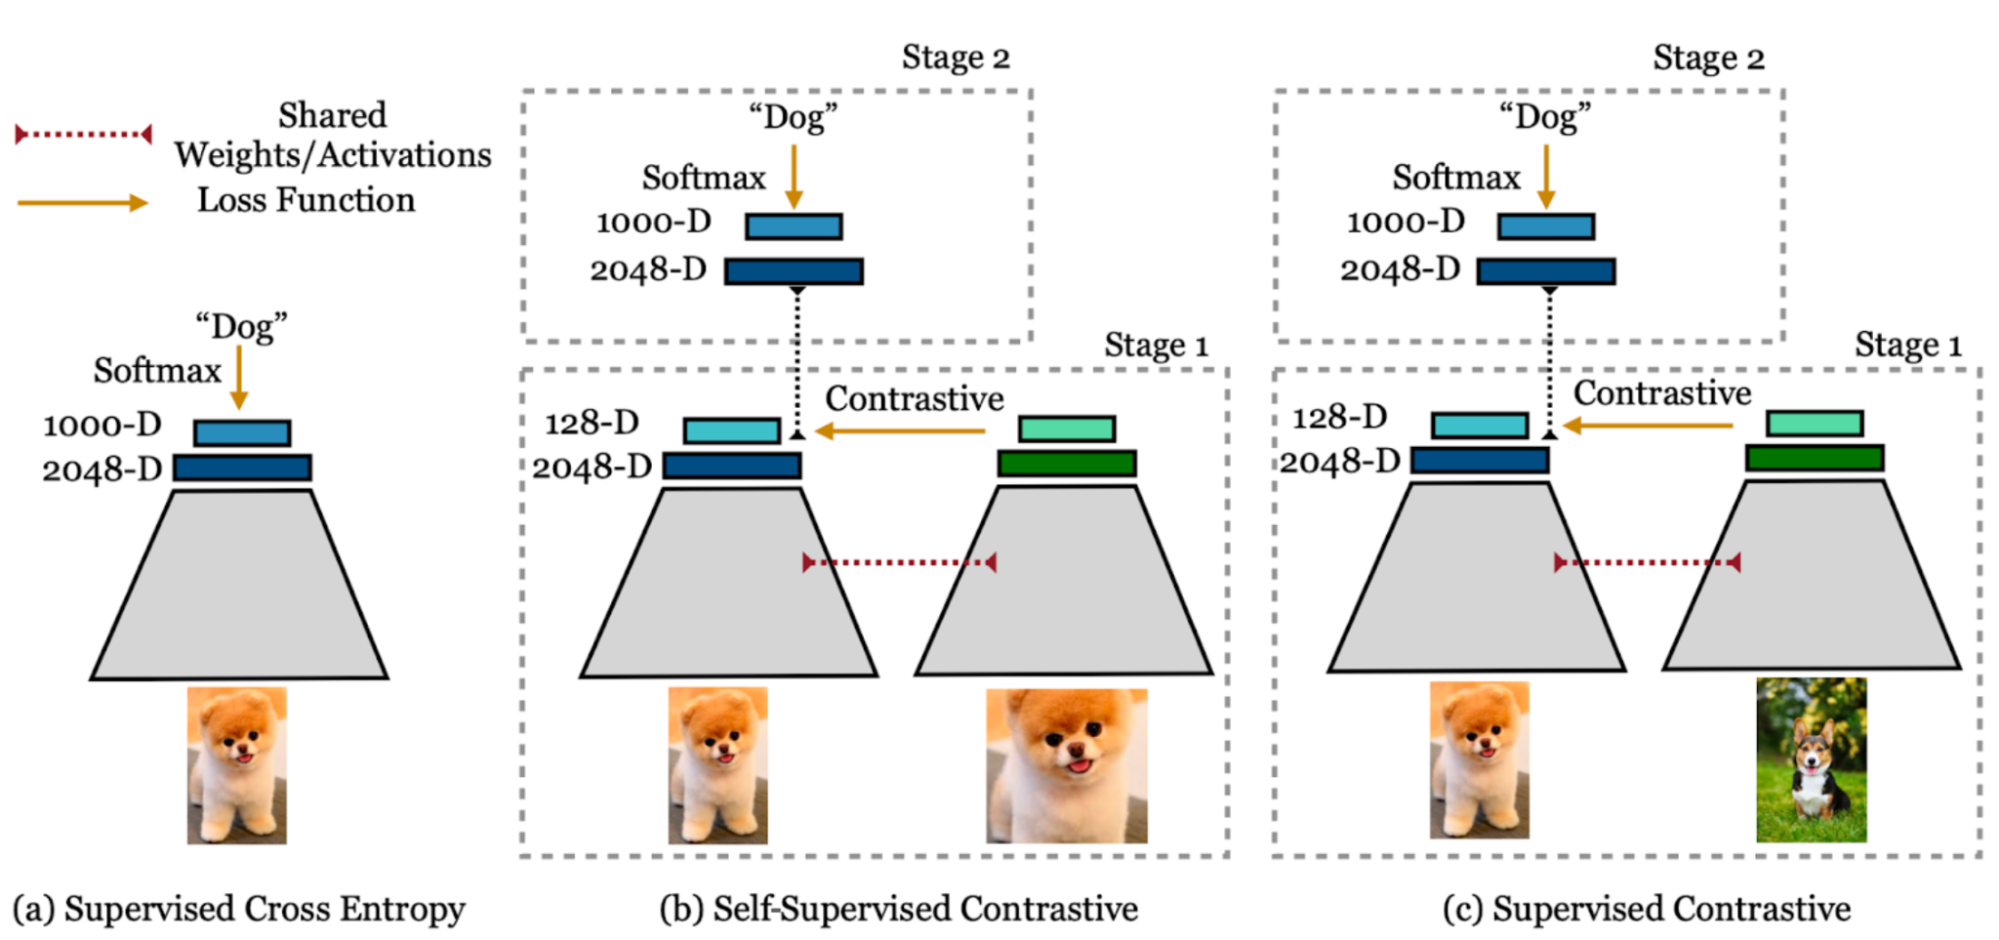

# CLIP

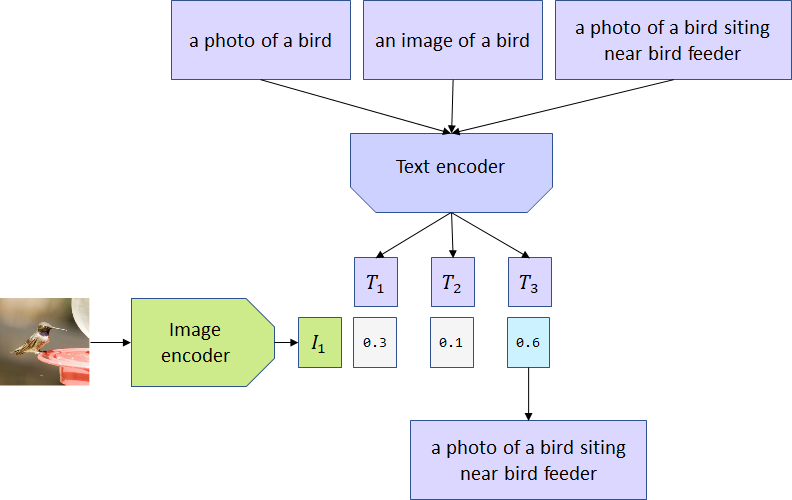

# In this notebook, you will:
- Use a pre-trained CLIP model to get image & text embeddings.
- Compare **zero‑shot** predictions vs. a simple **k‑NN** trained on a small labeled subset.
- Visualize the resulting embedding space with **t‑SNE** and **UMAP**.

## Setup
We will download the necessary packages and libraries

In [1]:

# If running on Google Colab, run this cell.
# (It's safe to re-run; installs will be cached across sessions when possible.)
!pip -q install git+https://github.com/openai/CLIP.git umap-learn scikit-learn matplotlib tqdm --upgrade


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00


## Imports & Device

In [2]:

import os
import random
import numpy as np
import torch
import clip
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import umap, requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [3]:
#simple function to get an image from its hyperlink
def load_image_from_url(url: str) -> Image.Image:
    """Fetch an image robustly with headers and basic validation."""
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=30)
    resp.raise_for_status()
    ctype = resp.headers.get("content-type", "")
    if "image" not in ctype:
        raise ValueError(f"URL did not return an image. content-type={ctype}")
    img = Image.open(BytesIO(resp.content)).convert("RGB")
    return img

## Demo on how CLIP compares image and text

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 41.0MiB/s]


Text(0.5, 1.0, 'Input image')

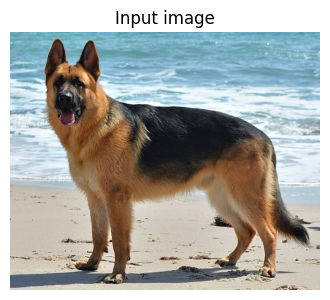

In [4]:
# Load the CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
# Load an image
# You can swap this URL with any image you like
image_url = "https://upload.wikimedia.org/wikipedia/commons/d/d0/German_Shepherd_-_DSC_0346_%2810096362833%29.jpg"  # German Shepherd

# candidate texts to compare (edit as you wish)
texts = [
    "a photo of a german shepherd dog",
    "a photo of a dog",
    "a photo of a cat",
    "a photo of an airplane",
    "a photo of a fish"
]

# Load & preprocess image
image = load_image_from_url(image_url)


# Show results
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.axis("off")
plt.title("Input image")

In [5]:

#Preprocess the image to feed it to CLIP image encoder
image_input = preprocess(image).unsqueeze(0).to(device)

# Tokenize text to feed it to CLIP text encoder
text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    # Encode
    image_features = model.encode_image(image_input)
    text_features  = model.encode_text(text_tokens)

    # Normalize to unit length (cosine similarity becomes dot product)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features  = text_features / text_features.norm(dim=-1, keepdim=True)

    # Similarity scores
    logits_per_image = image_features @ text_features.T  # shape: [1, len(texts)]
    probs = logits_per_image.softmax(dim=-1).squeeze(0).tolist()

print("Texts:", texts)
print("Cosine similarities (unnormalized logits):", logits_per_image.squeeze(0).tolist())
print("Probabilities via softmax over the prompts:")
for t, p in zip(texts, probs):
    print(f"  {t} : {p:.4f}")

Texts: ['a photo of a german shepherd dog', 'a photo of a dog', 'a photo of a cat', 'a photo of an airplane', 'a photo of a fish']
Cosine similarities (unnormalized logits): [0.33837890625, 0.2822265625, 0.208251953125, 0.1656494140625, 0.197998046875]
Probabilities via softmax over the prompts:
  a photo of a german shepherd dog : 0.2206
  a photo of a dog : 0.2085
  a photo of a cat : 0.1936
  a photo of an airplane : 0.1855
  a photo of a fish : 0.1917


# Experiments on CIFAR10 Dataset



## Config: Subset Size & Batch Size

In [6]:
# Keep the dataset small for faster run.
TRAIN_SAMPLES = 2000   # increase if you have a stronger GPU
TEST_SAMPLES  = 2000
BATCH_SIZE    = 128


# CIFAR-10 classes
CIFAR10_LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Prompt templates often help CLIP zero-shot performance
PROMPT_TEMPLATE = "a photo of a {}"


## Load CIFAR‑10 (Small Subset)

In [7]:
# CLIP preprocessing (ImageNet-like)
preprocess = clip.load("ViT-B/32", device=device)[1]

# We'll also keep a standard transform for visualization convenience
to_pil = T.ToPILImage()

trainset_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
testset_full  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

# Subsample for speed
train_indices = np.random.choice(len(trainset_full), size=TRAIN_SAMPLES, replace=False)
test_indices  = np.random.choice(len(testset_full),  size=TEST_SAMPLES,  replace=False)

trainset = Subset(trainset_full, train_indices)
testset  = Subset(testset_full,  test_indices)

def collate_fn(batch):
    imgs, labels = zip(*batch)
    imgs = [preprocess(img) for img in imgs]
    return torch.stack(imgs), torch.tensor(labels)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)

print(f"Train subset: {len(trainset)} images, Test subset: {len(testset)} images")


100%|██████████| 170M/170M [00:18<00:00, 9.00MB/s]


Train subset: 2000 images, Test subset: 2000 images


## Peek at a Few Samples

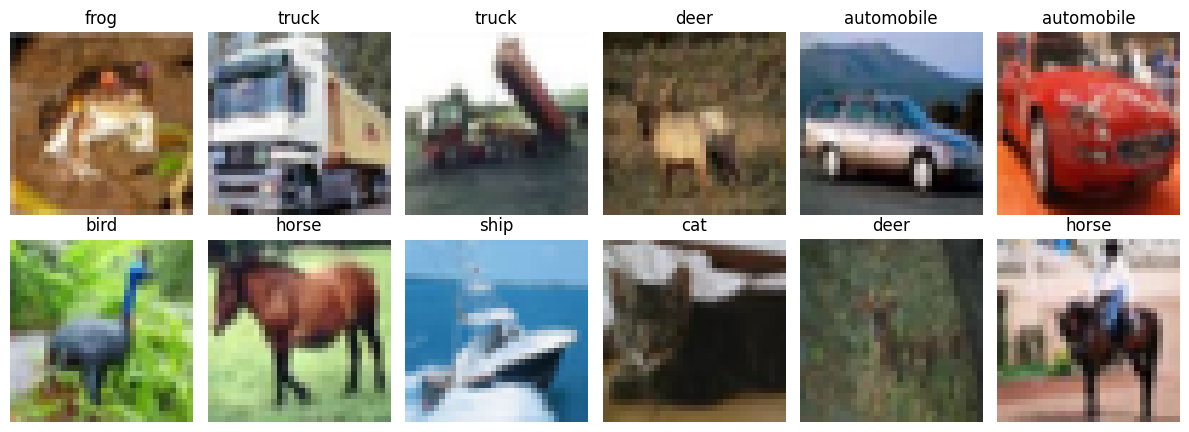

In [8]:

def show_samples(dataset, n=12):
    cols = 6
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(12, 2.2*rows))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(CIFAR10_LABELS[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 12 random training samples
show_samples(trainset_full, n=12)


## Build CLIP model & encode text label prompts

In [9]:

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Prepare text prompts for zero-shot classification
prompts = [PROMPT_TEMPLATE.format(c) for c in CIFAR10_LABELS]
with torch.no_grad():
    text_tokens = clip.tokenize(prompts).to(device)
    text_embeds = model.encode_text(text_tokens)
    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)  # normalize
text_embeds.shape, prompts[:4]


(torch.Size([10, 512]),
 ['a photo of a airplane',
  'a photo of a automobile',
  'a photo of a bird',
  'a photo of a cat'])

## Utility: Compute CLIP image embeddings

In [10]:
@torch.no_grad()
def embed_images(dataloader, model, device="cpu"):
    all_embeds = []
    all_labels = []
    for images, labels in tqdm(dataloader, total=len(dataloader)):
        images = images.to(device)
        image_embeds = model.encode_image(images)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)  # normalize
        all_embeds.append(image_embeds.cpu())
        all_labels.append(labels)
    return torch.cat(all_embeds, dim=0).numpy(), torch.cat(all_labels, dim=0).numpy()

train_X, train_y = embed_images(train_loader, model, device)
test_X,  test_y  = embed_images(test_loader,  model, device)

train_X.shape, test_X.shape


100%|██████████| 16/16 [00:04<00:00,  3.50it/s]


((2000, 512), (2000, 512))

## Zero‑Shot Classification (Text Prompts vs. Image Embeddings)

In [11]:

@torch.no_grad()
def zero_shot_predict(image_embeds, text_embeds):
    # cosine similarity equals dot product since both are normalized
    sims = image_embeds @ text_embeds.T  # [N, num_classes]
    preds = sims.argmax(axis=1)
    return preds, sims

zs_preds_train, _ = zero_shot_predict(torch.tensor(train_X), text_embeds.cpu().numpy())
zs_preds_test,  _ = zero_shot_predict(torch.tensor(test_X),  text_embeds.cpu().numpy())

zs_train_acc = accuracy_score(train_y, zs_preds_train)
zs_test_acc  = accuracy_score(test_y,  zs_preds_test)

print(f"Zero-Shot Accuracy -> Train: {zs_train_acc:.3f}, Test: {zs_test_acc:.3f}")
print("Classification report (Test):")
print(classification_report(test_y, zs_preds_test, target_names=CIFAR10_LABELS, zero_division=0))


Zero-Shot Accuracy -> Train: 0.886, Test: 0.899
Classification report (Test):
              precision    recall  f1-score   support

    airplane       0.96      0.93      0.95       185
  automobile       0.89      0.97      0.92       201
        bird       0.85      0.89      0.87       215
         cat       0.87      0.87      0.87       199
        deer       0.93      0.76      0.84       205
         dog       0.87      0.91      0.89       198
        frog       0.96      0.81      0.88       196
       horse       0.80      0.98      0.88       199
        ship       0.96      0.98      0.97       199
       truck       0.96      0.90      0.93       203

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



/tmp/ipython-input-3356393937.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sims = image_embeds @ text_embeds.T  # [N, num_classes]


## Supervised k‑NN on CLIP Embeddings

In [12]:
K_NEIGHBORS=15

def knn_train_eval(train_X, train_y, test_X, test_y, k=5, metric='cosine'):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance')
    knn.fit(train_X, train_y)
    preds = knn.predict(test_X)
    acc = accuracy_score(test_y, preds)
    return knn, preds, acc

knn, knn_preds_test, knn_acc_test = knn_train_eval(train_X, train_y, test_X, test_y, k=K_NEIGHBORS, metric='cosine')
print(f"k-NN (k={K_NEIGHBORS}, metric='cosine') Test Accuracy: {knn_acc_test:.3f}")
print("Classification report (Test):")
print(classification_report(test_y, knn_preds_test, target_names=CIFAR10_LABELS, zero_division=0))


k-NN (k=15, metric='cosine') Test Accuracy: 0.906
Classification report (Test):
              precision    recall  f1-score   support

    airplane       0.93      0.92      0.93       185
  automobile       0.96      0.94      0.95       201
        bird       0.96      0.82      0.89       215
         cat       0.79      0.87      0.83       199
        deer       0.88      0.86      0.87       205
         dog       0.96      0.84      0.90       198
        frog       0.77      0.96      0.86       196
       horse       0.96      0.95      0.96       199
        ship       0.99      0.96      0.97       199
       truck       0.92      0.94      0.93       203

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



## Accuracy vs. k (k‑NN) & Comparison to Zero‑Shot

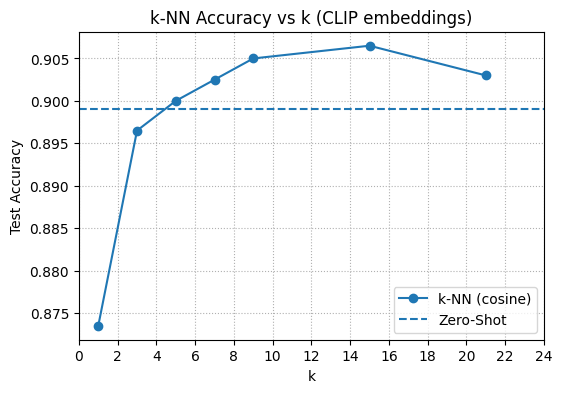

In [13]:

ks = [1, 3, 5, 7, 9, 15, 21]
accs = []
for k in ks:
    _, _, acc = knn_train_eval(train_X, train_y, test_X, test_y, k=k, metric='cosine')
    accs.append(acc)

plt.figure(figsize=(6,4))
plt.plot(ks, accs, marker='o', label='k-NN (cosine)')
plt.axhline(y=accuracy_score(test_y, zs_preds_test), linestyle='--', label='Zero-Shot')
plt.xlabel("k")
plt.ylabel("Test Accuracy")
plt.xticks(np.arange(0,25,2))
plt.title("k-NN Accuracy vs k (CLIP embeddings)")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()



## Visualizing the Embedding Space: t‑SNE vs UMAP

**t‑SNE** is great at revealing local clusters but can distort global structure and can be slow on large datasets.  
**UMAP** preserves more of the global structure and typically runs faster, while still capturing local neighborhoods.

We'll embed the **test set** CLIP embeddings into 2D with both methods and color points by their **ground‑truth labels**.


Running t-SNE... (can take ~1–3 minutes)
Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipython-input-1867931824.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(all_labels))


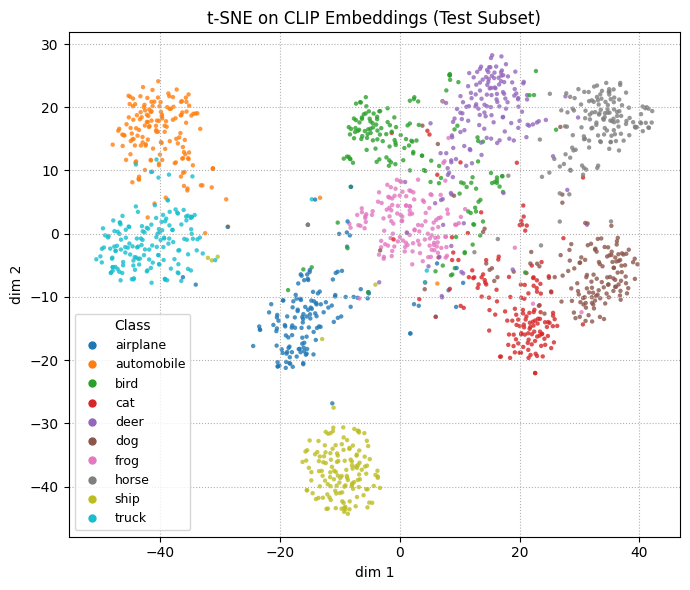

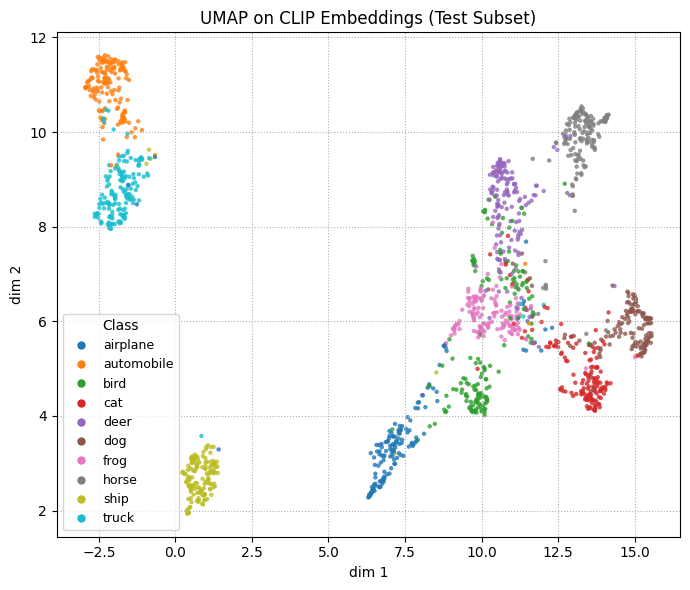

In [14]:

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

# To keep runtime modest, we'll visualize a smaller slice if needed.
VIS_MAX = min(1500, len(test_X))
vis_X = test_X[:VIS_MAX]
vis_y = test_y[:VIS_MAX]
vis_labels = [CIFAR10_LABELS[i] for i in vis_y]

print("Running t-SNE... (can take ~1–3 minutes)")
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
vis_tsne = tsne_2d.fit_transform(vis_X)

print("Running UMAP...")
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=SEED)
vis_umap = umap_2d.fit_transform(vis_X)



def scatter_2d(coords, labels, title, all_labels=None):
    plt.figure(figsize=(7,6))

    # Use a stable label order (e.g., CIFAR10_LABELS) so colors match across plots
    if all_labels is None:
        all_labels = sorted(set(labels))  # fallback to whatever is present

    label_set = set(labels)
    shown_labels = [l for l in all_labels if l in label_set]

    # Map labels -> integers deterministically
    label_to_id = {lbl: i for i, lbl in enumerate(all_labels)}
    ids = [label_to_id[lbl] for lbl in labels]

    # Shared colormap & normalization across all possible classes
    cmap = plt.cm.get_cmap('tab10', len(all_labels))
    norm = mpl.colors.Normalize(vmin=0, vmax=len(all_labels)-1)

    # Scatter with cmap & norm so colors come from [0..n_classes-1]
    plt.scatter(coords[:, 0], coords[:, 1],
                c=ids, cmap=cmap, norm=norm,
                s=10, alpha=0.8, edgecolors='none')

    # Legend proxies with matching facecolors
    proxies = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=6,
               markerfacecolor=cmap(label_to_id[l]), markeredgecolor='none')
        for l in shown_labels
    ]
    plt.legend(proxies, shown_labels, loc='best', title="Class", fontsize=9)

    plt.title(title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

# Keep colors consistent between t-SNE and UMAP by passing the same all_labels ordering
ALL = CIFAR10_LABELS  # or whatever master list you use
scatter_2d(vis_tsne, vis_labels, "t-SNE on CLIP Embeddings (Test Subset)", all_labels=ALL)
scatter_2d(vis_umap, vis_labels, "UMAP on CLIP Embeddings (Test Subset)", all_labels=ALL)



## Visualize Predicted Labels (Zero‑Shot vs k‑NN)

To get intuition, let's color the same UMAP projection by **predicted labels** from zero‑shot and k‑NN.


/tmp/ipython-input-1867931824.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(all_labels))


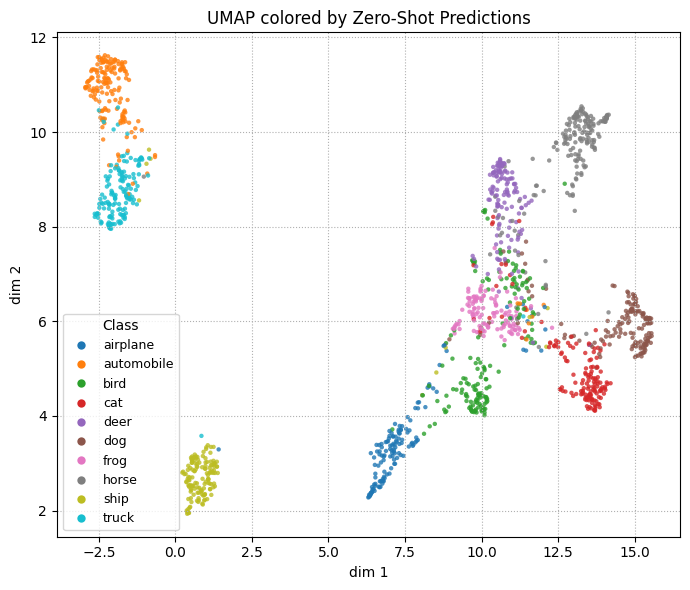

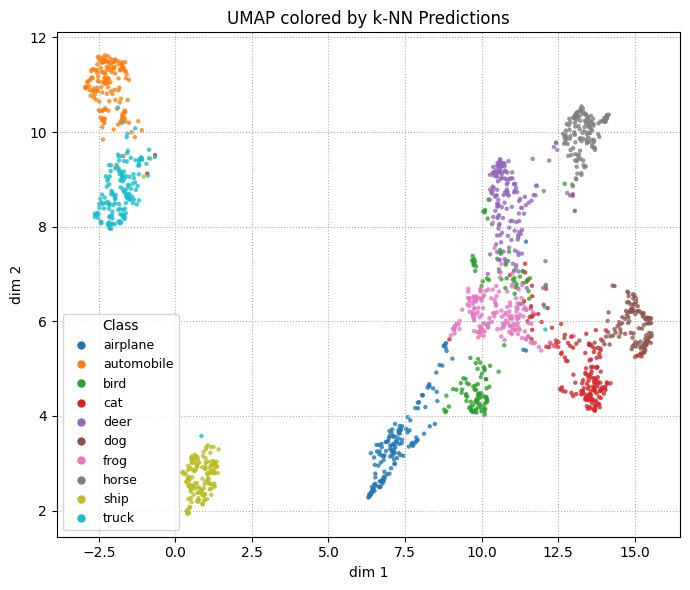

In [15]:

vis_zs = zs_preds_test[:VIS_MAX]
vis_knn = knn_preds_test[:VIS_MAX]

zs_labels = [CIFAR10_LABELS[i] for i in vis_zs]
knn_labels = [CIFAR10_LABELS[i] for i in vis_knn]

scatter_2d(vis_umap, zs_labels, "UMAP colored by Zero‑Shot Predictions")
scatter_2d(vis_umap, knn_labels, "UMAP colored by k‑NN Predictions")


## Confusion Matrices

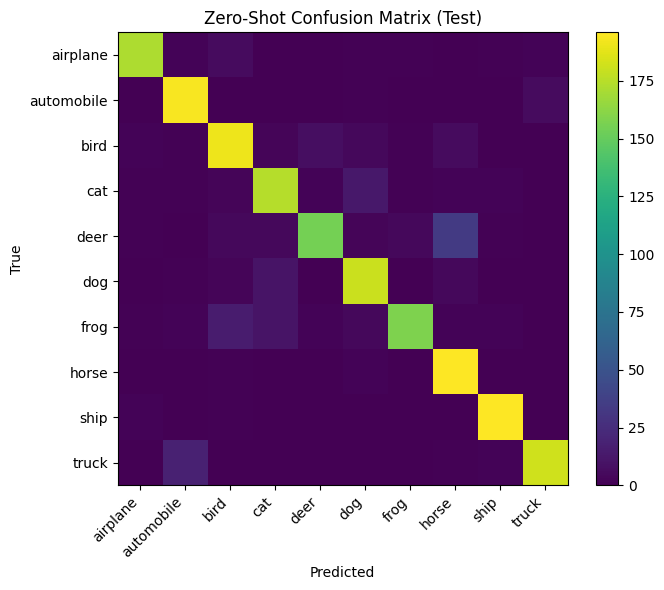

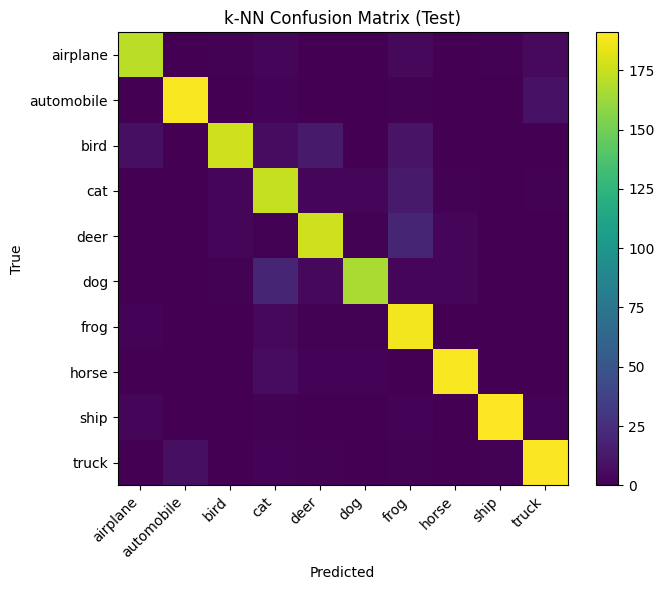

In [16]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

cm_zs = confusion_matrix(test_y, zs_preds_test, labels=list(range(len(CIFAR10_LABELS))))
cm_knn = confusion_matrix(test_y, knn_preds_test, labels=list(range(len(CIFAR10_LABELS))))

plot_confusion_matrix(cm_zs,  CIFAR10_LABELS, "Zero‑Shot Confusion Matrix (Test)")
plot_confusion_matrix(cm_knn, CIFAR10_LABELS, "k‑NN Confusion Matrix (Test)")



## (Optional) Explore: Prompt Engineering for Zero‑Shot

CLIP is sensitive to the **prompt** used. Try changing `PROMPT_TEMPLATE` or using multiple templates and **averaging** their text embeddings.

Example templates:
- `"a photo of a {}"` *(default)*
- `"a blurry photo of a {}"`
- `"a close-up photo of a {}"`
- `"this is a photo of a {}"`

You can also try class-specific prompt sets.


In [17]:

# Example: average multiple prompt templates
templates = [
    "a photo of a {}",
    "a blurry photo of a {}",
    "a close-up photo of a {}",
    "this is a photo of a {}",
]

with torch.no_grad():
    text_embeds_multi = []
    for cls in CIFAR10_LABELS:
        toks = clip.tokenize([t.format(cls) for t in templates]).to(device)
        embeds = model.encode_text(toks)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)
        text_embeds_multi.append(embeds.mean(dim=0))
    text_embeds_multi = torch.stack(text_embeds_multi, dim=0)
    text_embeds_multi = text_embeds_multi / text_embeds_multi.norm(dim=-1, keepdim=True)

zs_preds_test_multi, _ = zero_shot_predict(torch.tensor(test_X), text_embeds_multi.cpu().numpy())
print("Zero-Shot (multi-prompt) Test Acc:", accuracy_score(test_y, zs_preds_test_multi))


Zero-Shot (multi-prompt) Test Acc: 0.8965


/tmp/ipython-input-3356393937.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sims = image_embeds @ text_embeds.T  # [N, num_classes]



## Appendix: Notes & Tips

- **Why cosine?** CLIP embeddings are often normalized, so cosine similarity reduces to a dot product.
- **Speed tips:** Reduce `TRAIN_SAMPLES`, `TEST_SAMPLES`, or `VIS_MAX` to speed up t‑SNE/UMAP.
- **GPU:** If Colab gives you a T4 or better, this runs quickly. On CPU only, expect longer runtimes.
- **Extending:** Try different CLIP backbones (e.g., `ViT‑L/14`)
